## 프로젝트 1. 경사 하강법으로 이미지 복원하기

지금까지 Autograd의 사용법과 경사 하강법에 대해서 봤지만, 아직 정확한 구현법과 머신러닝에서의 쓰임새에 대해서는 깊게 다뤄보지 못했습니다.  
물론 파이토치는 대부분의 학습과 최적화 알고리즘들을 제공해 주기 때문에 직접 경사 하강법을 구현할 일은 거의 없습니다.
그래도 기본적인 머신러닝의 학습방법을 이해하는 것은 앞으로 더 깊게 딥러닝을 공부하기 위해선 필수적이라고 거듭 말씀드리고 싶습니다.
그런 취지에서 이번 프로젝트를 통해 아주 간단한 모델과 오차함수, 그리고 모델의 학습동작까지 파이토치의 도움을 살짝 배제하고 코딩해 보도록 하겠습니다.
직접 구현한 경사 하강법을 이용해 모델의 오차값을 최소화 시키므로써 일반적의 머신러닝 학습 메카니즘을 배워 보는것이 이번 프로젝트의 목표입니다.

### 프로젝트 개요와 목표

이번 프로젝트에서 우리가 풀 문제는 다음과 같습니다.
weird_function() 이라는 함수가 original_image 라고 하는 어느 이미지 파일을 입력받아 broken_image 라는 오염된 이미지를 리턴했습니다. 우리는 이 오염된 이미지와 원본 이미지를 동시에 파일로 저장하려고 했으나, 모종의 이유로 원본 이미지 파일은 삭제된 상황입니다.
다행히도 weird_function()의 소스코드는 삭제되지 않았습니다.
우리의 목표는 오염된 이미지와 weird_function()의 코드만을 가지고 원본 이미지 파일을 복원하는 것입니다.

### 문제 접근

대부분의 프로그래머는 다음과 같이 문제에 접근할겁니다.

```python
1. weird_function()의 소스코드를 분석한다.

2. 분석을 토대로 weird_function()의 동작을 반대로 이행하는 함수를 구현한다.

3. 2에서 구현한 함수에 broken_image를 입력시켜 복구된 이미지를 출력한다.
```

솔직히 위의 해결책은 꽤 합리적인 해결책입니다. 
하지만 weird_function()의 모든 동작을 되돌리려면 함수의 동작을 모두 직접 일일히 파악해야 하며,
이것은 함수에 대한 설명이나 사전지식이 없으면 아주 오래걸리고 까다로운 작업입니다.

우리가 택할 해결책은 좀 더 머신러닝과 수학적 최적화에 가까운 방법입니다만, 이 방법을 선택하기까진 다음과 같은 사고과정이 필요합니다.

```python
1. broken_image 와 사이즈가 같은 random_tensor 라는 랜덤한 이미지를 생성한다.

2. random_tensor를 weird_function()에 입력시켜 hypothesis 라고 하는 이미지를 출력한다.

[팩트] 원본 이미지인 original_image가 weird_function()에 입력되어 broken_image를 출력했다.

[팩트] 인위적으로 생성한 random_tensor가 weird_function()에 입력되어 hypothesis를 출력했다.

3. 그러므로 hypothesis 와 broken_image 가 같은 이미지라면, random_tensor 와 original_image도 같은 이미지일 것이다.

4. weird_function()을 수정키지 않는 대신, random_tensor를 조금씩 변경시켜 weird_functino(random_tensor) = broken_image 라는 관계가 성립하도록 한다.
```

이번 장에서 배워봤듯, 모델이 학습한다는 것은 모델이 출력한 결과값과 정답의 차이, 즉 오차(Loss)값이 최소화 된다는 뜻이기도 합니다.
우리가 이 문제에서 최소화 시키고자 하는 오차값은 모델의 결과값인 hypothesis 와 '정답'이라고 할 수 있는 broken_image 사이의 거리값 입니다.

이 거리값을 파이토치의 Autograd를 이용해 random_tensor로 미분하여 오차의 최소값이 있는 방향을 알아냅니다. 그리고 그 방향으로 random_tensor를 Learning Rate라는 수만큼 조금씩 변경시켜 주는 것이 바로 경사하강법의 기본입니다.

지금까지 이 문제의 해결법과 접근법, 그리고 구체적인 경사하강법에 대해서 전보다 깊게 배워봤습니다. 지금부터는 이 문제의 답안 코드를 함께 코딩 해 보고, 결과를 확인해 보겠습니다.

In [577]:
%matplotlib inline
import torch
import pickle
import matplotlib.pyplot as plot


In [578]:
shp_original_img = (100, 100)
broken_image =  torch.FloatTensor( pickle.load(open('./broken_image_t.p', 'rb'),encoding='latin1' ) )

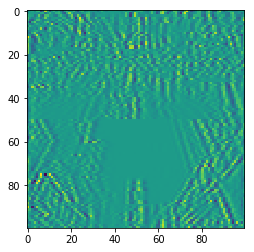

In [579]:
plot.imshow(  broken_image.view(100,100) ) 

In [580]:
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for ii in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if ii % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

In [581]:
def distance_loss(hypothesis, broken_image):    
    return torch.dist(hypothesis, broken_image, 2)

In [582]:
random_tensor = torch.randn(10000, dtype = torch.float)
print(random_tensor)
print(weird_function(random_tensor))

tensor([ 0.2561, -1.4784, -1.9960,  ..., -0.1852,  0.7645, -2.1264])
tensor([ 0.1516, -0.1036, -0.2665,  ..., -0.0838, -0.0019,  0.0238])


In [583]:
lr = 0.8
for i in range(0,20000):
    random_tensor.requires_grad_(True)
    hypothesis = weird_function(random_tensor)
    loss = distance_loss(hypothesis, broken_image)
    loss.backward()
    with torch.no_grad():
        random_tensor = random_tensor - lr*random_tensor.grad
    if i % 1000 == 0:
        print('Loss at ', i, ' = ', loss.item())
    


Loss at  0  =  12.090258598327637
Loss at  1000  =  1.1304563283920288
Loss at  2000  =  0.5384575724601746
Loss at  3000  =  0.3744213879108429
Loss at  4000  =  0.2969752848148346
Loss at  5000  =  0.24860896170139313
Loss at  6000  =  0.21340151131153107
Loss at  7000  =  0.18535934388637543
Loss at  8000  =  0.16165657341480255
Loss at  9000  =  0.14076030254364014
Loss at  10000  =  0.12176588177680969
Loss at  11000  =  0.10410811007022858
Loss at  12000  =  0.08742041885852814
Loss at  13000  =  0.07145684957504272
Loss at  14000  =  0.056048400700092316
Loss at  15000  =  0.041077621281147
Loss at  16000  =  0.026463929563760757
Loss at  17000  =  0.021158630028367043
Loss at  18000  =  0.021166445687413216
Loss at  19000  =  0.021167738363146782


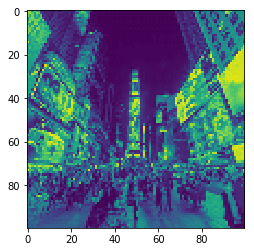

In [584]:

plot.imshow(  random_tensor.view(100,100).data  )

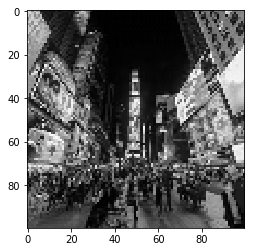

In [585]:
plot.imshow(  random_tensor.view(100,100).data,cmap = 'gray')


In [586]:
#Sources are based on https://github.com/jcjohnson/pytorch-examples, NYU Intro2ML